In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/DSPG Models/working_shap/house_present"

/content/drive/MyDrive/Colab Notebooks/DSPG Models/working_shap/house_present


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
import cv2
import os

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
data_dir = os.getcwd()+'/data'

In [6]:
image_size = (256, 256)

X = []
y = []

for subdir in os.listdir(data_dir):
    label = 0 if subdir == 'house_present' else 1
    subdir_path = os.path.join(data_dir, subdir)
    for file in os.listdir(subdir_path):
        image_path = os.path.join(subdir_path, file)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, image_size)
        X.append(resized_image)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Loaded image shape:", X.shape)
print("Loaded label shape:", y.shape)


# X = X.reshape(X.shape[0], *image_size, 3).astype("float32") / 255
# y = y.reshape(y.shape[0])
X = X.astype("float32") / 255


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_split_train, x_split_validation, y_split_train, y_split_validation = train_test_split(X_train, y_train, train_size=0.8)


Loaded image shape: (468, 256, 256, 3)
Loaded label shape: (468,)


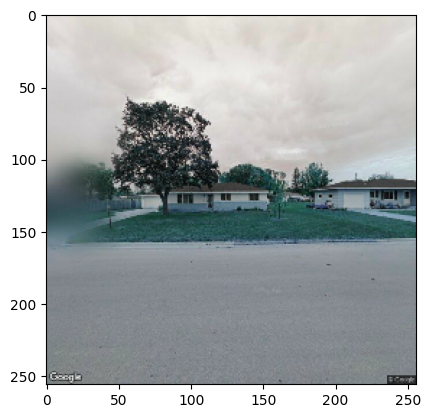

In [7]:
plt.imshow(x_split_train[0])

In [ ]:
model = Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same', input_shape=(256,256,3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(64, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(keras.layers.Conv2D(64, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(keras.layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=opt,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3)
with tf.device('/device:GPU:0'):
  history = model.fit(x_split_train, y_split_train, validation_data=(x_split_validation, y_split_validation), epochs = 80, verbose=1, callbacks=[reduce_lr])

10/10 [==============================] - 2s 222ms/step - loss: 0.3003 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.3315 - val_sparse_categorical_accuracy: 0.9733 - lr: 3.0518e-08
Epoch 49/80
10/10 [==============================] - 2s 223ms/step - loss: 0.2913 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.3314 - val_sparse_categorical_accuracy: 0.9733 - lr: 3.0518e-08
Epoch 50/80
10/10 [==============================] - 2s 227ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.3315 - val_sparse_categorical_accuracy: 0.9733 - lr: 1.5259e-08
Epoch 51/80
10/10 [==============================] - 2s 231ms/step - loss: 0.2607 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.3315 - val_sparse_categorical_accuracy: 0.9733 - lr: 1.5259e-08
Epoch 52/80
10/10 [==============================] - 2s 224ms/step - loss: 0.2999 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.3315 - val_sparse_categorical_accuracy: 0.9733 - lr: 1.5259e-08
Epoch 53/80
10/10 [===

In [11]:
def summarize_diagnostics(history):
    # plot loss
    plt.figure()
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='test')

In [12]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])

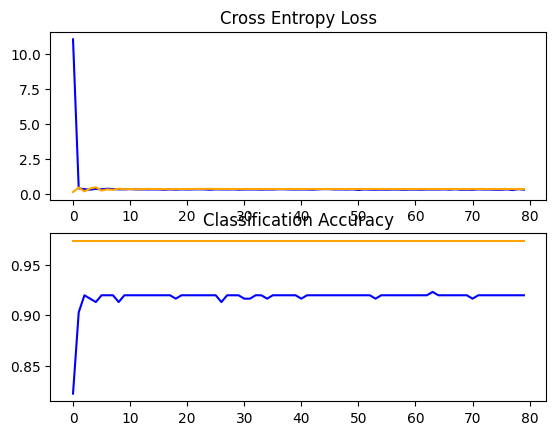

In [13]:
summarize_diagnostics(history)

In [14]:
final_model = Sequential()
final_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same', input_shape=(256,256,3)))
final_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
final_model.add(keras.layers.MaxPooling2D((2, 2)))
final_model.add(keras.layers.Dropout(0.25))
final_model.add(keras.layers.Conv2D(64, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
final_model.add(keras.layers.Conv2D(64, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
final_model.add(keras.layers.MaxPooling2D((2, 2)))
final_model.add(keras.layers.Dropout(0.25))
final_model.add(keras.layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
final_model.add(keras.layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
final_model.add(keras.layers.MaxPooling2D((2, 2)))
final_model.add(keras.layers.Dropout(0.25))
final_model.add(keras.layers.Flatten())
final_model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
final_model.add(keras.layers.Dropout(0.25))
final_model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
final_model.add(keras.layers.Dropout(0.25))
final_model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
final_model.add(keras.layers.Dropout(0.25))
final_model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                        

In [15]:
obtained_learning_rate = np.array(history.history['lr'])

In [16]:
def scheduler(epoch):
  return obtained_learning_rate[epoch]

In [17]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
final_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=opt,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

In [19]:
with tf.device('/device:GPU:0'):
  final_history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 80, verbose=1, callbacks=[callback])

12/12 [==============================] - 3s 231ms/step - loss: 0.2593 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.4586 - val_sparse_categorical_accuracy: 0.9043 - lr: 1.2500e-04
Epoch 12/80
12/12 [==============================] - 3s 228ms/step - loss: 0.2612 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.4410 - val_sparse_categorical_accuracy: 0.9043 - lr: 1.2500e-04
Epoch 13/80
12/12 [==============================] - 3s 228ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.4378 - val_sparse_categorical_accuracy: 0.9043 - lr: 1.2500e-04
Epoch 14/80
12/12 [==============================] - 3s 227ms/step - loss: 0.2514 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.4369 - val_sparse_categorical_accuracy: 0.9043 - lr: 6.2500e-05
Epoch 15/80
12/12 [==============================] - 3s 227ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.4501 - val_sparse_categorical_accuracy: 0.9043 - lr: 6.2500e-05
Epoch 16/80
12/12 [===

In [20]:
result = final_model.evaluate(X_test, y_test, verbose=1)

3/3 [==============================] - 0s 70ms/step - loss: 0.4435 - sparse_categorical_accuracy: 0.9043


In [21]:
result[1]*100

90.42553305625916

In [22]:
final_model.save('shap_house_present_model.h5')